In [4]:
!git clone https://github.com/JustinCheung168/domain-generalization-ct.git

Cloning into 'domain-generalization-ct'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
try:
  import google.colab
  IN_COLAB = True
  print("In Google Colab")
except:
  IN_COLAB = False
  print("Not in Google Colab")

if IN_COLAB:
  %pip install medmnist

Not in Google Colab


In [1]:
print('test')

test


In [ ]:
from enum import Enum
from typing import Optional, Tuple, List

# Datasets
from medmnist import OrganAMNIST

# Progress bar
from tqdm import tqdm

# Image display
import matplotlib.pyplot as plt

# Image manipulation
from PIL import Image
import numpy as np
from scipy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from scipy.ndimage import rotate


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/justincheung/Projects/Python/JHU/EN.605.740/domain-generalization-ct/env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/Users/justincheung/Projects/Python/JHU/EN.605.740/domain-generalization-ct/env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/justincheung/Projects/Python/JHU/EN.605.740/domai

In [ ]:
class Display:
  @staticmethod
  def imshow(img: np.ndarray, axes: Optional[plt.Axes] = None,
             title: Optional[str] = None,
             window: Optional[Tuple[float, float]] = None,
             title_stats: bool = False):
    """
    Display grayscale image with preferred settings.
    Recommend window=(0, 255) for 8-bit images.
    """
    if axes is None:
      fig, axes = plt.subplots(1, 1)

    if title is None:
      if title_stats:
        axes.set_title(Display.stat_string(img))
      else:
        axes.set_title(title)
    else:
      if title_stats:
        axes.set_title(title+"\n"+Display.stat_string(img))
      else:
        axes.set_title(title)

    if window is None:
      window = (None, None)

    axes.imshow(img, cmap='gray', vmin=window[0], vmax=window[1])
    axes.axis('off')

  @staticmethod
  def stat_string(img: np.ndarray) -> str:
    """Produce a string with common simple statistics of interest"""
    return f"Max: {np.nanmax(img):.4f}" + \
           f"\nMin: {np.nanmin(img):.4f}" + \
           f"\nMean: {np.nanmean(img):.4f}" + \
           f"\nStdev: {np.nanstd(img):.4f}" + \
           f"\n#NaN: {np.isnan(img).sum()}"

  @staticmethod
  def imshow_diff(img_new: np.ndarray, img_old: np.ndarray,
                  window: Optional[Tuple[float, float]] = None,
                  title_stats: bool = False):
    """Display the difference between two images for comparative purposes."""
    img_diff = img_new - img_old
    img_absdiff = np.abs(img_diff)

    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    Display.imshow(img_new, axes[0], title=f"New", title_stats=title_stats, window=window)
    Display.imshow(img_old, axes[1], title=f"Old", title_stats=title_stats, window=window)
    Display.imshow(img_diff, axes[2], title=f"New - Old", title_stats=title_stats, window=window)
    Display.imshow(img_absdiff, axes[3], title=f"|New - Old|", title_stats=title_stats, window=window)


In [ ]:
dataset = OrganAMNIST(split='train',download=True)
print(len(dataset), "images in the dataset")

34561 images in the dataset


<Figure size 1000x800 with 0 Axes>

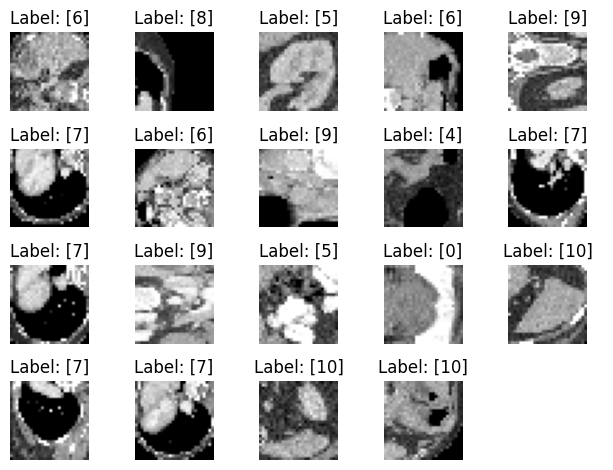

In [ ]:
# Look at the dataset
num_images_to_display = 19
num_images_per_display_row = 5
#----

num_display_rows = int(np.ceil(num_images_to_display / num_images_per_display_row))

plt.figure(figsize=(num_images_per_display_row*2, num_display_rows*2))

# Make subplots without visible axes
fig, axes_lst = plt.subplots(num_display_rows, num_images_per_display_row)
for i in range(num_images_per_display_row * num_display_rows):
  axes_lst[i // num_images_per_display_row][i % num_images_per_display_row].axis('off')

for i in range(num_images_to_display):
  img, label = dataset[i]
  Display.imshow(np.asarray(img), axes=axes_lst[i // num_images_per_display_row][i % num_images_per_display_row],
                 title = f"Label: {label}", window=(0, 255))

plt.tight_layout()
plt.show()

In [ ]:
class Padder:
  def __init__(self, pad_sz: Optional[int] = None):
    if pad_sz is None:
      # Pad the image to the size of its diagonal. This should allow safe
      # rotation of the image without losing information.
      max_dimension = max(img.shape)
      diagonal = np.sqrt(2) * max_dimension
      self.pad_sz = int(np.ceil((diagonal - max_dimension) / 2))
    else:
      self.pad_sz = pad_sz

  def pad(self, arr: np.ndarray):
    return np.pad(arr, self.pad_sz, mode="constant", constant_values=0)

  def unpad(self, arr: np.ndarray):
    return arr[self.pad_sz:-self.pad_sz, self.pad_sz:-self.pad_sz]

class KernelType(Enum):
  RAMP = 0
  HANN_RAMP = 1

class Projector:
  """
  Implements discrete Radon transform (forward projection)
  and its inverse (backprojection).

  For demonstration purposes only. `skimage.transform.radon` is recommended -
  it is far more optimized, and this code has some issue with normalization
  which `skimage.transform.radon` handles correctly.

  Args:
    n_detectors: The number of simulated detectors used in forward projection.
      Because projection is done by summing across rows in this implementation,
      this must equal the number of rows in the image before forward projection.
    recon_width: The number of columns to give the result of backprojection.
      In this simulation, you likely want this to equal the number of columns
      in the image before forward projection.
    angles_deg: An array of angles (in degrees) at which to sample a given image
      during forward projection.
    kernel_type: The type of filter to apply to the sinogram before
      backprojection. For now, KernelType.HANNING_RAMP is recommended.
  """

  # ===== PUBLIC METHODS =====

  def __init__(self, n_detectors: int, recon_width: int,
               angles_deg: np.ndarray, kernel_type: KernelType):
    self.n_detectors = n_detectors
    self.recon_width = recon_width
    self.angles_deg = angles_deg
    self.n_angles = len(angles_deg)

    # The next highest power of 2 after the size of the sinogram.
    # Used to expedite FFT.
    self.n_detectors_pow2 = 2 ** int(np.ceil(np.log2(n_detectors)))

    self.kernel = self._calculate_kernel(self.n_detectors_pow2, kernel_type)

  def forward_project(self, img: np.ndarray):
    """
    Build the sinogram of `img`.

    Projections are taken across rows of `img`.

    Args:
      img: A 2D array of shape (n_detectors, _) representing the image.

    Returns:
      A 2D array of shape (n_angles, n_detectors) representing the sinogram.
    """
    assert img.shape[0] == self.n_detectors, "Image must have same number of rows as the initialized number of detectors"

    sinogram = np.zeros((self.n_angles, self.n_detectors))

    dl = 1.0 / img.shape[1]

    for i_angle in tqdm(range(self.n_angles), desc="Forward Projection"):
      # Rotate the image CCW by the i-th angle.
      angle_deg = self.angles_deg[i_angle]
      img_rotated = rotate(img, angle_deg, reshape=False)

      # Project across rows.
      # Each summation approximates integration along the X-ray beam's path
      # with step size dl.
      proj = np.sum(img_rotated, axis=1) * dl

      # Save projection as a row of the sinogram.
      sinogram[i_angle, :] = proj

    return sinogram

  def filtered_backprojection(self, sinogram: np.ndarray):
    """
    Reconstruct the image from the `sinogram`.

    Args:
      sinogram: A 2D array of shape (n_angles, n_detectors) representing the
        sinogram.

    Returns:
      A 2D array of shape (n_detectors, recon_width) representing the
      reconstructed image.
    """
    return self._backproject(self._filter_sinogram(sinogram))

  # ===== PRIVATE METHODS =====

  def _calculate_kernel(self, n: int, kernel_type: KernelType):
    """
    Derive the appropriate kernel to filter the sinogram with prior to
    backprojection.

    Most kernels are a variant of a ramp function, which combats the effect of
    the oversampling of the image center during backpropagation.
    This ramp function is usually apodized to avoid amplifying
    high-frequency noise.

    Args:
      n: Kernel size. Assumed to be a power of 2.

    Returns:
      A 1D array of shape (n,) representing the kernel. This can be applied
      by elementwise multiplication in the discrete Fourier domain.
    """
    # All kernels are some function of normalized discrete frequency f,
    # covering domain [-1/2 ... 1/2)
    f = fftshift(fftfreq(n))

    if kernel_type == KernelType.RAMP:
      kernel = np.abs(f)
    elif kernel_type == KernelType.HANN_RAMP:
      kernel = np.abs(f)

      # Apodize the ramp using a Hann window.
      # The prepended 0 corresponds to the highest frequency.
      apodizer = np.concatenate(([0], np.hanning(n-1)))

      kernel = kernel * apodizer
    else:
      raise ValueError(f"Unknown apodization type: {kernel_type}")

    # Normalize the kernel to sum to 1 so that on average,
    # a filtered signal's magnitude is unmodified.
    kernel = kernel / np.sum(kernel)

    # Circularly shift the kernel so that discrete frequencies are nonnegative.
    kernel = ifftshift(kernel)

    return kernel

  def _filter_sinogram(self, sinogram):
    """
    Filter each row (projection) of the sinogram with the precalculated kernel
    through multiplication in the discrete Fourier domain.

    The sinogram is padded row-wise to the next highest power of 2
    to expedite FFT.
    """
    # Perform discrete Fourier transform on each projection.
    # Central Slice Theorem provides that these are slices of the discrete Fourier domain.
    dft_slices = fft(sinogram, n=self.n_detectors_pow2, axis=1)

    # Filter the slices in discrete Fourier domain.
    dft_slices = dft_slices * self.kernel

    # Return to sinogram space.
    sinogram_filtered = ifft(dft_slices, axis=1)

    # Remove the padding applied during FFT.
    sinogram_filtered = sinogram_filtered[:,:self.n_detectors]

    return sinogram_filtered

  def _backproject(self, sinogram: np.ndarray):
    """
    Reconstruct the image from the `sinogram`.
    Does not include the filtering that combats oversampling.

    Args:
      sinogram: A 2D array of shape (n_angles, n_detectors) representing the
        sinogram.

    Returns:
      A 2D array of shape (n_detectors, recon_width) representing the
      reconstructed image.
    """
    assert sinogram.shape[0] == self.n_angles, "Sinogram must have same number of rows as the initialized number of angles"
    assert sinogram.shape[1] == self.n_detectors, "Sinogram must have same number of columns as the initialized number of detectors"

    img_recon = np.zeros((self.n_detectors, self.recon_width))

    # Assume that the spacing between angles remains constant.
    d_angle = np.deg2rad(np.mean(np.diff(self.angles_deg)))
    dl = 1.0 / self.recon_width

    for i_angle in tqdm(range(self.n_angles), desc="Backprojection"):

      # Get the i-th projection from the sinogram.
      proj = sinogram[i_angle, :]

      # Replicate the projection in the rows direction to form one backprojection.
      backproj = np.tile(proj, (self.recon_width, 1)).T

      # Rotate the backprojection back to the angle it was originally taken from during forward projection.
      angle_deg = self.angles_deg[i_angle]
      backproj_unrotated = rotate(backproj, -angle_deg, reshape=False)

      # Add this backprojection as a contribution to the final image.
      img_recon = img_recon + backproj_unrotated * d_angle * dl

    # FFT during any filtering transforms data to complex values.
    # Assume negligible imaginary component and return real component.
    print()
    return np.real(img_recon)

class SinogramCorruptor:
  """
  Adds an artifact in the sinogram.
  """
  def create_multiplicative_ring_artifact(self, sinogram: np.ndarray, detectors: List[int], factors: List[float]):
    """
    Create a ring artifact characterized by a detector only receiving a certain
    fraction of incoming X-rays.

    For example, setting `detectors` to [5, 7] and `factors` to [0.2, 0.5]
    causes detector at index 5 to receive only 20% of the incoming X-rays,
    and detector at index 7 to receive only 50% of the incoming X-rays.

    Args:
      sinogram: A 2D array of shape (n_angles, n_detectors) representing the
        sinogram.
      detectors: A list of detector indices that will receive the artifact.
      factors: A list of multiplicative factors by which to multiply each
        detector. One element in `factors` corresponds to one index in
        `detectors`.

    Returns:
      A 2D array of shape (n_angles, n_detectors) representing the corrupted sinogram.
    """
    assert len(detectors) == len(factors), "Must provide a factor for each detector"

    corrupted_sinogram = sinogram.copy()
    for i in range(len(detectors)):
      corrupted_sinogram[:, detectors[i]] = corrupted_sinogram[:, detectors[i]] * factors[i]

    return corrupted_sinogram

In [ ]:
# img = np.asarray(dataset[0][0])

from skimage.transform import resize
img = np.asarray(Image.open('SheppLogan.png').convert('L'))
img = resize(img, (32, 32))


padder = Padder()

img_pad = padder.pad(img)

projector = Projector(
  n_detectors = img_pad.shape[0],
  recon_width = img_pad.shape[1],
  angles_deg = np.linspace(0, 180, num=720, endpoint=False),
  kernel_type = KernelType.RAMP
)

sinogram = projector.forward_project(img_pad)

# corruptor = SinogramCorruptor()
# sinogram = corruptor.create_multiplicative_ring_artifact(sinogram, detectors=[img.shape[0]//3, img.shape[0]//4, img.shape[0]*4//5], factors=[0.2, 0.5, 0.0])

img_recon_pad = projector.filtered_backprojection(sinogram)

img_recon = padder.unpad(img_recon_pad)

Backprojection: 100%|██████████| 720/720 [00:00<00:00, 731.72it/s]

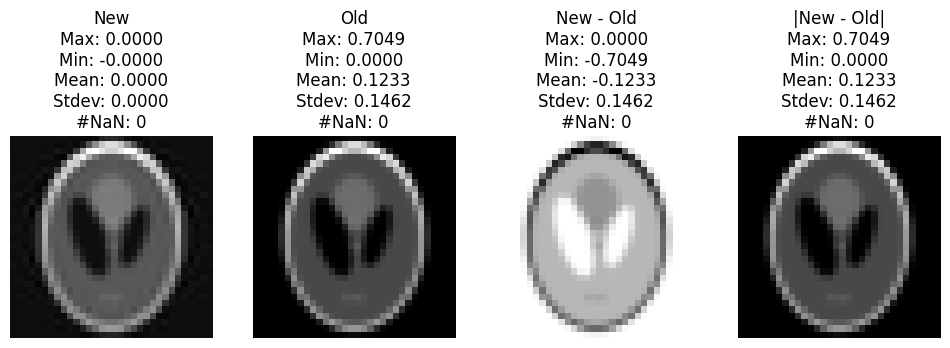

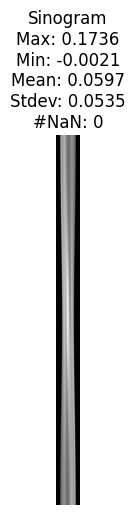

In [ ]:

Display.imshow_diff(img_recon, img, title_stats=True, window=None)
Display.imshow(sinogram, title="Sinogram", title_stats=True)